### Cambridge property mapping

An experimental notebook as I develop map-visualization skills and try to learn something about Cambridge.

For my data set, I used the Cambridge Assessing Department's on-line property database file for FY16, FY17, and FY18. It is supposed to include "residential, condo, commercial and exempt data". I wanted to see which regions of the city and which particular properties have unusual assessed values, values-per-square-foot, or valuation growth rates.

The original data set is available from the City of Cambridge. Go to the link below and click the "Export" button at the upper-right corner of the page:

https://data.cambridgema.gov/Assessing/Cambridge-Property-Database-FY16-FY18/eey2-rv59

List of data cleaning issues:
- Many fields have values that must be data entry errors, including:
    - YearOfAssessment: many numbers way off being a year. Likely LandArea values instead.
    - ResidentialExemption: should be True/False, got many TaxDistrict values instead.
    - SaleDate: Many dates with invalid years such as 25335; might be Book/Page partial values.
    - Owner_State: some values from Owner_City
    - Exterior_Style: some numeric data from Owner_Zip
    - Exterior_WallType: some numeric data likely from Exterior_NumStories
    - Exterior_RoofType: some numeric data likely from Exterior_WallHeight
    - Exterior_RoofMaterial: some numeric data, similar values to Exterior_WallHeight but not adjacent to that column, unlike most of the other shifted values.
    - Exterior_View: numeric data, likely from Exterior_FloorLocation and Exterior_RoofMaterial. Should be qualitative scale Average / Good / Very Good / Excellent / Fair / Poor / River View
    - Interior_NumUnits: numeric but with some implausible values, such as 4.81250e+04, 1.86786e+05 (more than one unit per resident of Cambridge!)
    - Interior_TotalRooms: again, values such as 3.36500e+05 can’t be real.
    - Interior_Kitchens: several numeric values that are misplaced.
    - Interior_Flooring: several numeric values that are misplaced
    - Interior_Layout: definitely some values from Interior_Flooring. I think the likely valid values are: Thru Unit / Corner Unit / nan, and possibly also Poor / Superior / No Impact
    - Interior_LaundryInUnit: should be boolean / nan, but several other text values are present.
    - Systems_HeatType: Mostly OK except for TRUE / FALSE
    - Systems_CentralAir: seems like it should be binary, but has other values from System_HeatType possibly
    - Systems_Plumbing: invalid Gas / FALSE / TRUE / Other / Oil / Electric
    - Condition_YearBuilt: looks OK at a glance except for 0
    - Condition_InteriorCondition: many year values
    - Condition_OverallCondition: many year values
- A pretty large fraction of records, almost 10% are listed with AssessedValue == 0, for reasons I don't yet know. Some of these rows even have SalePrice > 0, up to X00,000! The huge majority are PropertyClass == 'CONDO_BLDG' (7912 instances), followed by 'Private College' (50 instances). It's possible these are data entry errors. I found that many but not all of these rows are filled with 0.0 / 'None" / np.nan - like values in all of the property physical characteristics.
- SaleDate is supposed to be a date but has a lot of unparseable corrupted data. Also, the most common value is '01/01/1900' which surely means 'before record keeping began'.
- The number of records increased slightly each year, which I expect will be new construction.

Description of fields, taken from "property_database_2015_metadata.xlsx":

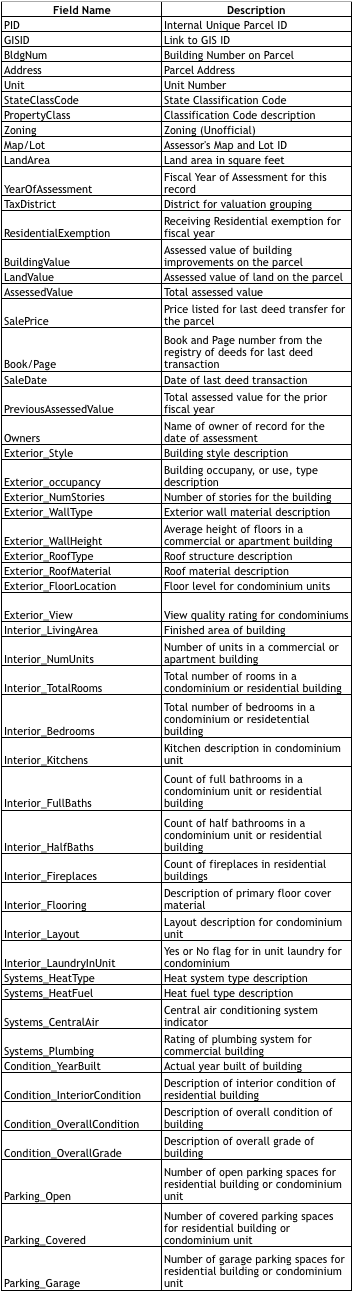

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mapboxgl
import pysal.esda.mapclassify as mapclassify
token = 'pk.eyJ1IjoibWJyb21hbm93c2t5IiwiYSI6ImNqbHk2NHIwcTFvNG4za29kaXptdGx4eHcifQ.1wudvgV_q8udxQXadRTrpw'

HOUSING_ONLY = True

/Users/mark/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
# read in the data

df = pd.read_csv('./Cambridge_Property_Database_FY16-FY18.csv')
print(df.shape)

(86703, 61)


/Users/mark/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (12,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Survey the data in the various columns; numerous data-entry errors are revealed.

for col in df:
    print(f'\nUnique values for {col}: \n', df[col].unique())


Unique values for PID: 
 [1063 3397 5439 ...  290  694  351]

Unique values for GISID: 
 ['23-67' '77-81' '97-91' ... '180-74' '183-130' '194-90']

Unique values for BldgNum: 
 [ 2  1  3  4  5  6  7  8  9 10 13 22 16 25 24 18 14 27 21 23 26 32 31 11
 12 17 15 19 33 36 35 29 20 28 30 34 37 38]

Unique values for Address: 
 ['117 119 Otis St\nCambridge, MA\n'
 '100A 102 Hampshire St\nCambridge, MA\n'
 '531 Putnam Ave\nCambridge, MA\n(42.357686, -71.10856)' ...
 '7 Foster Pl\nCambridge, MA\n(42.376323384000045, -71.12939521999994)'
 '50 Sparks St\nCambridge, MA\n(42.37725448100008, -71.13019627899996)'
 '50 Shepard St\nCambridge, MA\n(42.38056872400006, -71.12389163199998)']

Unique values for Unit: 
 [nan '2A' '229/1' ... '2017-04-20T00:00:00' '2017-06-15T00:00:00'
 '2017-06-23T00:00:00']

Unique values for StateClassCode: 
 [ 199  102  109  424  346 9100  942  111  910 1099  104  105  390  316
  132  930   13  337  936  130  121  112  340 1098  101  345  325  392
  336  406 1322  370 1


Unique values for Exterior_FloorLocation: 
 [nan  2.  1.  3.  4.  8. 11.  5.  6. 12. 20.  7. 19. 21.  9. 17. 10. 23.
 15. 18. 14. 13. 16. 24. 25. 22.]

Unique values for Exterior_View: 
 [nan 'Average' 'RUBBER-MEMBRAN' 'TAR-GRAVEL' 'ASPHALT-SHNG' 'Good'
 'SLATE-CLAY' '1' 'Very Good' 'Excellent' 'OTHER' 'Fair' 'METAL'
 'ROLL-ROOFING' 'Poor' 'River View' 'WOOD-SHINGLE' '3' '2' 'TILE' '11'
 'COMPOSITION']

Unique values for Interior_LivingArea: 
 [   0.  557.  686. ... 6863. 6175. 4161.]

Unique values for Interior_NumUnits: 
 [0.00000e+00         nan 2.00000e+00 1.00000e+00 6.00000e+00 4.00000e+00
 3.00000e+00 1.10000e+01 1.30000e+01 2.40000e+01 5.00000e+00 7.00000e+00
 9.00000e+00 1.90000e+01 6.28000e+02 7.99700e+03 4.81250e+04 7.13600e+03
 7.98210e+04 2.47940e+04 8.56100e+03 3.55000e+02 1.38900e+03 2.10000e+01
 1.60000e+01 9.25200e+03 5.70000e+01 8.30000e+01 1.04000e+02 3.10000e+01
 2.00000e+01 1.20000e+01 4.60000e+01 2.22480e+04 5.40000e+01 1.99000e+02
 1.40000e+01 1.27000e+02 6.3800


Unique values for Systems_HeatType: 
 [nan 'Hot Water' 'Forced Air' 'SPACE-HEAT' 'HOT/CHLD-WTR' 'HOT-WATER'
 'Steam' 'HW Radiator' 'NONE' 'FORCED-AIR' 'Other' 'WRM/COOL-AIR'
 'Heat Pump' 'Space Heat' 'H.V.A.C.' 'STEAM' 'Elec Wall' 'H.V.A.C' 'TRUE'
 'FALSE' 'HEAT-PUMP' 'PACKAGE-A/C' 'HOT-WATR-RAD' 'OTHER' 'Elec-Radiant'
 'COMBINATION' 'None']

Unique values for Systems_HeatFuel: 
 [nan 'Gas' 'Other' 'Oil' 'Combination' 'Electric' 'Forced Air' 'Hot Water'
 'Steam' 'PACKAGE-A/C' 'HOT-WATER' 'Wood' 'None' 'STEAM' 'FORCED-AIR'
 'SPACE-HEAT' 'HOT/CHLD-WTR' 'HEAT-PUMP' 'H.V.A.C.' 'NONE' 'OTHER'
 'WRM/COOL-AIR' 'HOT-WATR-RAD']

Unique values for Systems_CentralAir: 
 ['FALSE' nan 'TRUE' 'PACKAGE-A/C' 'HOT-WATER' 'SPACE-HEAT' 'Gas'
 'H.V.A.C.' 'HOT/CHLD-WTR' 'STEAM' 'Oil' 'OTHER' 'HOT-WATR-RAD' 'NONE'
 'FORCED-AIR' 'Combination' 'WRM/COOL-AIR' 'HEAT-PUMP' 'None' '0' '1'
 'Other' 'Electric']

Unique values for Systems_Plumbing: 
 [nan 'NONE' 'GOOD' 'Gas' 'AVERAGE' 'FALSE' 'FAIR' 'POOR' 'TRUE' '

In [4]:
# These are the strings in df["PropertyClass"] that seem to indicate long-term housing.
# I excluded boarding house, dorm, hotel, parsonage, and other maybe-applicable categories.
# As discussed below, 'CONDO-BLDG' might be off-topic but will be filtered out in a later step.

housing_classes = [
                   'CONDO-BLDG', 'CONDOMINIUM', 'MULTIPLE-RES',
                   '4-8-UNIT-APT', 'MULT-RES->8 APT', 'TWO-FAM-RES', 'THREE-FM-RES',
                   'MULTIUSE-RES',
                   '>8-UNIT-APT', 'MULT-RES-4-8-APT',
                   'SNGL-FAM-RES',
                   'CNDO LUX', 
                   'MULT-RES-1FAM', 'MXD CONDOMINIUM',
                   'SINGLE FAM W/AUXILIARY APT', 'MULT-RES-2FAM',
                   'MULT-RES-3FAM',
                   'MULTI UNIT CNDO', 
                   'MXD >8-UNIT-APT',
                   'Housing',
                   'MXD 4-8-UNIT-APT',
                   'Housing, Other'
]

In [5]:
# Distinct housing properties (by PID) grouped by PropertyClass

df[df['PropertyClass'].isin(housing_classes)].groupby('PropertyClass')['PID'].count()

PropertyClass
4-8-UNIT-APT                   1769
>8-UNIT-APT                     888
CNDO LUX                       6513
CONDO-BLDG                     7912
CONDOMINIUM                   36217
Housing                           2
Housing, Other                    1
MULT-RES-1FAM                    38
MULT-RES-2FAM                    47
MULT-RES-3FAM                    31
MULT-RES-4-8-APT                156
MULT-RES->8 APT                  39
MULTI UNIT CNDO                   9
MULTIPLE-RES                    613
MULTIUSE-RES                    774
MXD 4-8-UNIT-APT                  4
MXD >8-UNIT-APT                   7
MXD CONDOMINIUM                   9
SINGLE FAM W/AUXILIARY APT      458
SNGL-FAM-RES                  11167
THREE-FM-RES                   3681
TWO-FAM-RES                    7387
Name: PID, dtype: int64

In [6]:
# Proceed with just rows representing housing. Row counts in comments below will be thrown off

if HOUSING_ONLY:
    df = df[df['PropertyClass'].isin(housing_classes)]

In [7]:
df['ValueIncrease'] = df['AssessedValue'] / df['PreviousAssessedValue'] - 1
df['AssessedValSqFoot'] = df['AssessedValue'] / df['Interior_LivingArea']

The Address field turned out to include latitude and longitude figures in every row from 2018, but not in 2017 or 2016. My first idea was to parse out the lat/lon from the 2018 rows and use them for the prior years, but that was overly clever: I don't plan to put more than one year on a map at a time. And many of the prior year rows had lat/lon, but often different in the 0.000X place. So I just took the lat/lon from each row's Address. If I need to be extremely complete in the future, I can go back through the 2016-2017 rows, find one that are missing lat/lon, and match by PID to the 2018 data... but I doubt that will be necessary.

In [8]:
# Extract lat/lon coordinates from Address; discard rows with no Address since they can't be used on map
df = df.dropna(subset=['Address'])

df['Coordinates'] = df['Address'].apply(lambda x: x.split('\n')[2])

# Create Latitude and Longitude columns
# I get a SettingWithCopyWarning, I think because df2018['Coordinates'] is a copy and it's unclear whether I
# mean to mutate it with .apply(). In this case I don't want to mutate and it's good that the copy gets thrown out!

def lat(x):
    if len(x) > 0:
        return float(x.split(',')[0].replace('(', ''))
    else:
        return np.nan
    
def lon(x):
    if len(x) > 0:
        return float(x.split(',')[1].replace(')', ''))
    else:
        return np.nan
    
df['Latitude'] = df['Coordinates'].apply(lat)
df['Longitude'] = df['Coordinates'].apply(lon)

# Drop the no longer needed Coordinates column
df = df.drop(columns=['Coordinates'])

In [9]:
mask = (df["AssessedValue"] > 0) & (df['PreviousAssessedValue'] > 0)
df_positive = df[mask]
df_positive = df_positive.reset_index(drop=True)

In [10]:
df['ValueIncrease'].describe()

count    6.992100e+04
mean              inf
std               NaN
min     -1.000000e+00
25%      7.625324e-02
50%      1.158670e-01
75%      1.316662e-01
max               inf
Name: ValueIncrease, dtype: float64

In [11]:
df['AssessedValSqFoot'].describe()

count    6.979400e+04
mean              inf
std               NaN
min      0.000000e+00
25%      4.331296e+02
50%      5.434446e+02
75%      6.571731e+02
max               inf
Name: AssessedValSqFoot, dtype: float64

The "infinite" values come from cases such as parcels under development, churches, parkland, and other structures not rated for living in. Maybe data entry errors too.

In [12]:
df['AssessedValue'].describe()

count    7.771500e+04
mean     9.969341e+05
std      3.887954e+06
min      0.000000e+00
25%      4.274000e+05
50%      6.325000e+05
75%      1.008800e+06
max      2.063508e+08
Name: AssessedValue, dtype: float64

Some properties have an assessed value of zero! What's going on with that?

In [13]:
dfzero = df[df['AssessedValue'] == 0]
print(dfzero.shape)
dfzero.head(10)

(7914, 65)


,PID,GISID,BldgNum,Address,Unit,StateClassCode,PropertyClass,Zoning,Map/Lot,LandArea,...,Condition_OverallGrade,Parking_Open,Parking_Covered,Parking_Garage,UnfinishedBasementGross,FinishedBasementGross,ValueIncrease,AssessedValSqFoot,Latitude,Longitude
0,1063,23-67,2,"117 119 Otis St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,23-67,3499.0,...,NaN,0.0,0.0,NaN,574.0,0.0,NaN,NaN,NaN,NaN
1,3397,77-81,1,"100A 102 Hampshire St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,77-81,1835.0,...,NaN,0.0,0.0,NaN,1430.0,0.0,NaN,NaN,NaN,NaN
2,5439,97-91,1,"531 Putnam Ave\nCambridge, MA\n(42.357686, -71...",NaN,199,CONDO-BLDG,C,97-91,2900.0,...,NaN,0.0,0.0,NaN,800.0,0.0,NaN,NaN,42.357686,-71.108560
3,1063,23-67,1,"117 119 Otis St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,23-67,3499.0,...,NaN,0.0,0.0,NaN,1308.0,0.0,NaN,NaN,NaN,NaN
6,1197,24-78,1,"62 64 Otis St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,24-78,5000.0,...,NaN,0.0,0.0,NaN,1335.0,0.0,NaN,NaN,NaN,NaN
7,1197,24-78,2,"62 64 Otis St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,24-78,5000.0,...,NaN,0.0,0.0,NaN,1625.0,0.0,NaN,NaN,NaN,NaN
9,18121,214-54,1,"23 Chauncy St\nCambridge, MA\n(42.379382, -71....",NaN,199,CONDO-BLDG,C-2,214-54,5104.0,...,NaN,0.0,0.0,NaN,2057.0,0.0,NaN,NaN,42.379382,-71.123069
10,1429,26-66,1,"263 265 Hurley St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,26-66,1878.0,...,NaN,0.0,0.0,NaN,1044.0,0.0,NaN,NaN,NaN,NaN
13,1534,26-178,1,"6 Fourth Street Pl\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,26-178,2520.0,...,NaN,0.0,0.0,NaN,900.0,0.0,NaN,NaN,NaN,NaN
14,1498,26-140,1,"157 5 Fifth St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,26-140,2426.0,...,NaN,0.0,0.0,NaN,920.0,0.0,NaN,NaN,NaN,NaN


7926 rows have $0 assessed value, out of total 85554 (after dropping ones without addresses). That's a big fraction! It's unclear at present why so big. As shown below, 5743 of them even have a SalePrice of more than 0 listed. They are overwhelmingly PropertyClass == 'CONDO_BLDG', which could be a clue.

Based on the other data-entry errors I identified, it's also possible that these rows are just mistakes, too.

In [14]:
dfzero[dfzero['SalePrice']>0]

,PID,GISID,BldgNum,Address,Unit,StateClassCode,PropertyClass,Zoning,Map/Lot,LandArea,...,Condition_OverallGrade,Parking_Open,Parking_Covered,Parking_Garage,UnfinishedBasementGross,FinishedBasementGross,ValueIncrease,AssessedValSqFoot,Latitude,Longitude
0,1063,23-67,2,"117 119 Otis St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,23-67,3499.0,...,NaN,0.0,0.0,NaN,574.0,0.0,NaN,NaN,NaN,NaN
1,3397,77-81,1,"100A 102 Hampshire St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,77-81,1835.0,...,NaN,0.0,0.0,NaN,1430.0,0.0,NaN,NaN,NaN,NaN
2,5439,97-91,1,"531 Putnam Ave\nCambridge, MA\n(42.357686, -71...",NaN,199,CONDO-BLDG,C,97-91,2900.0,...,NaN,0.0,0.0,NaN,800.0,0.0,NaN,NaN,42.357686,-71.108560
3,1063,23-67,1,"117 119 Otis St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,23-67,3499.0,...,NaN,0.0,0.0,NaN,1308.0,0.0,NaN,NaN,NaN,NaN
10,1429,26-66,1,"263 265 Hurley St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,26-66,1878.0,...,NaN,0.0,0.0,NaN,1044.0,0.0,NaN,NaN,NaN,NaN
13,1534,26-178,1,"6 Fourth Street Pl\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,26-178,2520.0,...,NaN,0.0,0.0,NaN,900.0,0.0,NaN,NaN,NaN,NaN
14,1498,26-140,1,"157 5 Fifth St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,26-140,2426.0,...,NaN,0.0,0.0,NaN,920.0,0.0,NaN,NaN,NaN,NaN
17,1633,32-90,1,"89 91 Sixth St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,32-90,2207.0,...,NaN,0.0,0.0,NaN,838.0,0.0,NaN,NaN,NaN,NaN
18,1633,32-90,2,"89 91 Sixth St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,32-90,2207.0,...,NaN,0.0,0.0,NaN,464.0,0.0,NaN,NaN,NaN,NaN
24,2471,40-183,1,"26 26A Plymouth St\nCambridge, MA\n",NaN,199,CONDO-BLDG,C-1,40-183,1274.0,...,NaN,0.0,0.0,NaN,932.0,0.0,NaN,NaN,NaN,NaN


In [15]:
del dfzero

I'll continue just with df_positive to avoid infinite values on the map.

In [16]:
# To avoid a bug in the df_to_geojson, reset index of dataframes (messed up by dropped rows)
df_positive = df_positive.reset_index(drop=True)

In [17]:
# Drop rows that are missing lat/lon, which can't be plotted

mask = df_positive['Latitude'].isna()
df_plottable = df_positive[~mask].reset_index(drop=True)

mapboxgl.utils.df_to_geojson(df_plottable, filename='output/filtered_by_year_val.geojson',
                properties=['Address', 'PropertyClass', 'YearOfAssessment', 'SalePrice', 'SaleDate',
                            'Condition_YearBuilt', 'Condition_InteriorCondition', 'Condition_OverallCondition',
                            'Condition_OverallGrade', 'AssessedValue', 'ValueIncrease', 'AssessedValSqFoot'],
                lat='Latitude', lon='Longitude', precision=7)

{'type': 'file',
 'filename': 'output/filtered_by_year_val.geojson',
 'feature_count': 68214}

In [18]:
def reverse_stops(color_stops):
    li = list(zip(*color_stops))
    rev_stops = [li[0], tuple(reversed(li[1]))]
    new_stops = list(zip(*rev_stops))
    new_stops_list = [list(i) for i in new_stops]
    return new_stops_list

In [19]:
def make_map(feature = 'ValueIncrease', year = 2018, fixed_scale = True):
    
    # set seed to ensure my fixed scale is actually repeated!
    
    np.random.seed(123456)
    
    if fixed_scale is True:
        scale_year = 2018
    else:
        scale_year = year
        
    mask =( (df_plottable['AssessedValSqFoot'] != np.inf) & (~df_plottable['AssessedValSqFoot'].isna()) &
           (~df_plottable['AssessedValue'].isna()) &
           (~df_plottable['Latitude'].isna()) & (df_plottable['YearOfAssessment']==scale_year))
    df_masked = df_plottable[mask]
    color_breaks = mapclassify.Natural_Breaks(df_masked[feature], k=8, initial = 1).bins
    color_stops = mapboxgl.utils.create_color_stops(color_breaks, colors='RdYlBu')
    
    radius_stops = [[y, 3*(y==year)] for y in [2016, 2017, 2018]]

    viz = mapboxgl.viz.GraduatedCircleViz('output/filtered_by_year_val.geojson',
                                access_token = token,
                                height='700px',
                                radius_property = 'YearOfAssessment',
                                radius_stops = radius_stops,
                                radius_function_type = 'match',
                                color_property=feature,
                                color_stops=reverse_stops(color_stops),
                                center=(-71.11, 42.375),
                                zoom=12.5)
    
    viz.show()
    return viz

Let's make all the maps!!!!

Live maps take a lot of memory, so I will include just a few. I saved PNGs for each feature / year combination.

In [20]:
viz = make_map(feature='AssessedValSqFoot', year=2018, fixed_scale=True)

First, look at AssessedValue in each year, from 2016-2018. I am using the same color scale for each year, based on the observed 2018 range of data.

2016:

![AssessedValue_2016.png](images/AssessedValue_2016.png)

2017:

![AssessedValue_2017.png](images/AssessedValue_2017.png)

2018:

![AssessedValue_2018.png](images/AssessedValue_2018.png)

Now let's look at ValueIncrease (relative to prior year), for each year.

2016:

![ValueIncrease_2016.png](images/ValueIncrease_2016.png)

2017:

![ValueIncrease_2017.png](images/ValueIncrease_2017.png)

2018:

![ValueIncrease_2018.png](images/ValueIncrease_2018.png)

Different neighborhoods showed up as comparatively cool spots in 2016 and 2017, and almost the whole city cooled off in 2018! This change may reflect the broader housing market, or Cambridge's place in it, or just a change in the City Assessor's procedures or expectations -- comparison to other regions would be helpful to decide the cause.

Another interesting fact is the VERY high values for ValueIncrease at the high end -- it's remarkable when properties increase in value by 2-10X in a single year! You can mouse over points of interest on the live map. When I checked several of the high outliers for ValueIncrease and then looked up what was there in real life, what I found were brand-new large apartment buildings. In such cases, we might have had a large hole in the ground in 2016-2017, then a functioning and inhabited apartment building in 2018, which offers a reasonable explanation for the rapid increase in AssessedValue. Below, for example, shows the most extreme outlier and much of its relevant data:

![ValueIncrease_2018_highlighted.png](images/ValueIncrease_2018_highlighted.png)

Where's the most precious land? Let's look at AssessedValSqFoot, value per square foot of living space.

2016:

![ValSqFoot_2016.png](images/ValSqFoot_2016.png)

2017:

![ValSqFoot_2017.png](images/ValSqFoot_2017.png)

2018:

![ValSqFoot_2018.png](images/ValSqFoot_2018.png)

Even in Harvard Square, I find myself very skeptical of the extreme outliers -- $19,900 per square foot is an unbelievable number. I think it's much more likely that certain classes of buildings require subtleties in how the floor space data is coded. As an example I have identified, I can point out several properties that are marked on the map as black circles -- they are listed as having 0 sq ft of living area, perhaps because they are not actually housing. Alternatively, I don't know how living area is apportioned among the different units in a condo building versus an apartment building. Finally, it's certainly possible that there were data entry errors in the column for living area, as there certainly were in some of the other "Interior_" columns.